In [1]:
import torch
import numpy as np

from counterfactuals.datasets import PolishBankDataset, WineDataset
from counterfactuals.discriminative_models import MultilayerPerceptron

# from counterfactuals.losses import MulticlassDiscLoss
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.metrics.metrics import evaluate_cf

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib import cm

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device = "cpu"

In [17]:
# dataset = BlobsDataset("../data/blobs.csv")
dataset = PolishBankDataset("../data/polish_bankruptcy.csv")
# dataset = MoonsDataset("../data/moons.csv")
dataset = WineDataset("../data/wine.csv")
train_dataloader = dataset.train_dataloader(
    batch_size=128,
    shuffle=True,
    noise_lvl=0,
)
test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)

/Users/ofurman/Study/counterfactuals/counterfactuals/datasets/polish_bankruptcy.py:32: DtypeWarning: Columns (0,1,2,4,5,6,8,9,10,12,13,14,17,18,19,21,22,24,28,29,30,34,35,37,38,41,42,43,47,48,50,54,55,56,57,58,61) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(file_path, index_col=False)


(array([1, 2, 3]), array([59, 71, 48]))


/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [21]:
disc_model = MultilayerPerceptron(
    input_size=dataset.X_test.shape[1], target_size=3, hidden_layer_sizes=[256, 128]
)
disc_model.fit(
    dataset.train_dataloader(128, True),
    dataset.test_dataloader(128, False),
    epochs=500,
    lr=1e-5,
)
preds = disc_model.predict(dataset.X_test)
print(classification_report(dataset.y_test.flatten(), preds.numpy()))

Epoch 499, Train Loss: 0.9934, Test Loss: 0.9932: 100%|██████████| 500/500 [00:00<00:00, 506.57it/s]


              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.95      0.90      0.93        21
           2       0.88      1.00      0.94        15

    accuracy                           0.94        54
   macro avg       0.94      0.95      0.95        54
weighted avg       0.95      0.94      0.94        54



In [31]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X_test.shape[1],
    hidden_features=8,
    num_layers=2,
    context_features=1,
    device=device,
)
gen_model.fit(train_dataloader, test_dataloader, num_epochs=2000)

Epoch 1999, Train: -9.3864, test: -6.5891: 100%|██████████| 2000/2000 [00:08<00:00, 236.46it/s]


/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ValueError: Dimension 1 in inputs must be of size 13.

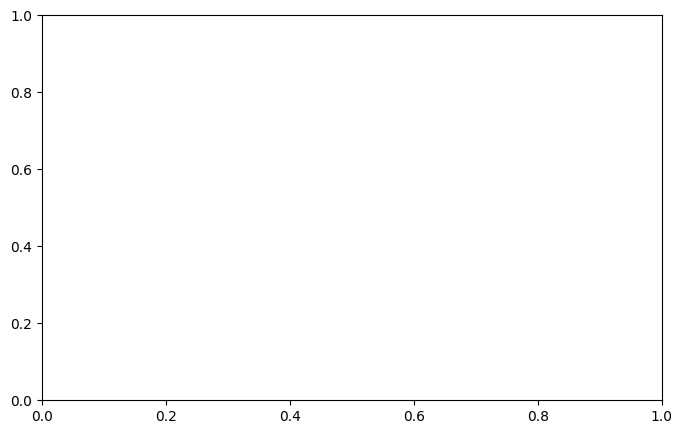

In [23]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 5)

xline = torch.linspace(-0.5, 1.5, 200)
yline = torch.linspace(-0.5, 1.5, 200)
xgrid, ygrid = torch.meshgrid(xline, yline)
xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

context_zero = torch.full((xyinput.shape[0], 1), 0, dtype=torch.float32)
context_one = torch.full((xyinput.shape[0], 1), 1, dtype=torch.float32)
context_two = torch.full((xyinput.shape[0], 1), 2, dtype=torch.float32)

with torch.no_grad():
    zgrid = gen_model(xyinput, context_one)
    zgrid = zgrid.reshape(200, 200).exp().numpy()

cs = ax.contourf(xgrid.numpy(), ygrid.numpy(), zgrid, levels=100, cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)  # noqa: F841

In [32]:
y_preds = []
with torch.no_grad():
    for x, y in zip(dataset.X_test, dataset.y_test):
        x = torch.from_numpy(x).view(1, -1)
        y_zero = torch.Tensor([0])
        y_one = torch.Tensor([1])
        y_two = torch.Tensor([2])
        y_pred = np.argmax(
            [
                gen_model(x, y_zero).item(),
                gen_model(x, y_one).item(),
                gen_model(x, y_two).item(),
            ]
        )
        y_preds.append(y_pred)
print(classification_report(dataset.y_test.flatten(), y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      0.95      0.98        21
           2       0.94      1.00      0.97        15

    accuracy                           0.98        54
   macro avg       0.98      0.98      0.98        54
weighted avg       0.98      0.98      0.98        54



In [28]:
# class MulticlassDiscLoss(torch.nn.modules.loss._Loss):
#     def __init__(
#         self, size_average=None, reduce=None, reduction: str = "mean", eps=0.02
#     ) -> None:
#         super().__init__(size_average, reduce, reduction)
#         self.eps = eps

#     def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
#         return torch.nn.functional.cross_entropy(input, target.view(-1))


class MulticlassDiscLoss(torch.nn.modules.loss._Loss):
    def __init__(
        self, size_average=None, reduce=None, reduction: str = "mean", eps=0.02
    ) -> None:
        super().__init__(size_average, reduce, reduction)
        self.eps = eps

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        one_hot = torch.eye(3)[target][:, 0, :]
        dot_product = torch.sum(input * one_hot, dim=1)
        return torch.norm(dot_product - torch.max(input, dim=1).values)

In [29]:
loss_fn = MulticlassDiscLoss()

In [30]:
cf = PPCEF(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=loss_fn,
    neptune_run=None,
    device="cpu",
)

In [31]:
delta = torch.median(gen_model.predict_log_prob(train_dataloader))
cf_dataloader = dataset.test_dataloader(batch_size=1024, shuffle=False)
Xs_cfs, Xs, ys_orig, ys_target, loss_components = cf.search_batch(
    cf_dataloader,
    epochs=5000,
    patience=200,
    lr=0.005,
    alpha=100,
    delta=delta,
)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:09<00:00,  9.14s/it]


In [32]:
loss_components.keys()

dict_keys(['cf_search/loss', 'cf_search/dist', 'cf_search/max_inner', 'cf_search/loss_disc'])

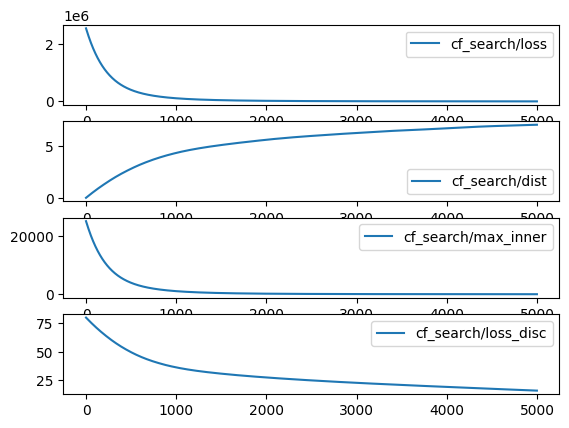

In [33]:
for i, (k, v) in enumerate(loss_components.items(), 1):
    plt.subplot(4, 1, i)
    plt.plot(v, label=k)
    plt.legend()

In [34]:
metrics = evaluate_cf(
    gen_model=gen_model,
    disc_model=disc_model,
    y_target=ys_target,
    X_cf=Xs_cfs,
    model_returned=np.ones(Xs_cfs.shape[0], dtype=bool),
    categorical_features=dataset.categorical_features,
    continuous_features=dataset.numerical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train.reshape(-1),
    X_test=dataset.X_test,
    y_test=dataset.y_test,
    delta=delta.numpy(),
)

In [35]:
metrics

{'model_returned_smth': 1.0,
 'valid_cf_disc': 0.006666666666666667,
 'dissimilarity_proximity_categorical_hamming': nan,
 'dissimilarity_proximity_categorical_jaccard': 0.0,
 'dissimilarity_proximity_continuous_manhatan': 9.848551855813712,
 'dissimilarity_proximity_continuous_euclidean': 7.02829663799913,
 'dissimilarity_proximity_continuous_mad': 1.8769437996546428,
 'distance_l2_jaccard': 7.02829663799913,
 'distance_mad_hamming': nan,
 'sparsity': 1.0,
 'flow_log_density_cfs': -20.26514,
 'flow_log_density_xs': -4.098318,
 'flow_prob_condition_acc': 0.34}